In [270]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping

In [271]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.857156,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.731959,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.883473,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.908735,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.804051,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2019-12-30,AMZN,0.748412,93.699997,94.199997,92.030998,92.344498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7532,2019-12-30,GOOG,0.676151,67.500000,67.650002,66.700996,66.806999,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7533,2019-12-30,GOOGL,0.705876,67.840500,67.849998,66.891998,66.985497,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7534,2019-12-30,MSFT,0.762997,158.990005,159.020004,156.729996,157.589996,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [272]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [273]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1252, 17)
            Date  p_sentiment       Open  ...        tcs    indpro     ccpi
0     2015-01-02     0.857156  27.847500  ...  1069010.0  102.8479  239.811
1     2015-01-05     0.744531  27.072500  ...  1069010.0  102.8479  239.811
2     2015-01-06     0.769826  26.635000  ...  1069010.0  102.8479  239.811
3     2015-01-07     0.773995  26.799999  ...  1069010.0  102.8479  239.811
4     2015-01-08     0.770458  27.307501  ...  1069010.0  102.8479  239.811
...          ...          ...        ...  ...        ...       ...      ...
1246  2019-12-20     0.775477  70.557503  ...  1458485.0  101.6179  265.651
1247  2019-12-23     0.759453  70.132500  ...  1458485.0  101.6179  265.651
1248  2019-12-24     0.742264  71.172501  ...  1458485.0  101.6179  265.651
1249  2019-12-26     0.670220  71.205002  ...  1458485.0  101.6179  265.651
1250  2019-12-27     0.760582  72.779999  ...  1458485.0  101.6179  265.651

[1251 rows x 17 columns]
AMZN (1257, 17)
            Date  p_sentiment 

In [274]:
ticker='TSLA'

In [275]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.741818,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.646626,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.696584,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.654833,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.615611,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [276]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [277]:
dates = pd.to_datetime(df['Date'])

In [278]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [279]:
df_for_training = df[cols].astype(float)

In [280]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [281]:
print(scaled_data)

[[0.78512475 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.57178167 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.68374619 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.47142104 0.97577552 0.99347221 ... 0.57323507 1.         1.        ]
 [0.38496901 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.44112774 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]]


In [282]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [283]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [284]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [285]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1250, 7, 16)
(1250, 1)


In [286]:
X_train=X[0:1125,:]
X_test=X[1125:,:]
y_train=y[0:1125,:]
y_test=y[1125:,:]

#early stopping


Epoch 1/100


6/6 [==============================] - 2s 51ms/step - loss: 0.0105 - val_loss: 0.0131
Epoch 2/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0172 - val_loss: 0.0080
Epoch 3/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0082 - val_loss: 0.0046
Epoch 4/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 5/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0019 - val_loss: 0.0078
Epoch 6/100
6/6 [==============================] - 0s 24ms/step - loss: 0.0024 - val_loss: 0.0092
Epoch 7/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0016 - val_loss: 0.0064


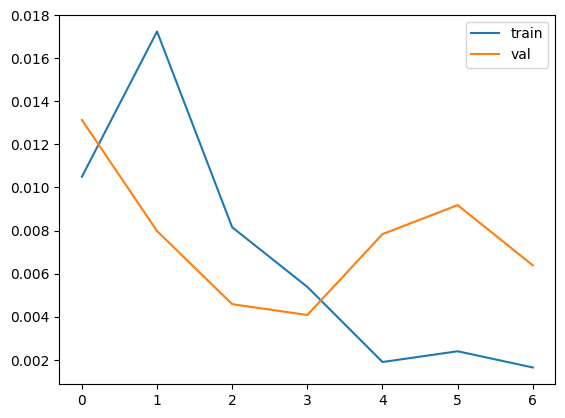

4/4 [==============================] - 0s 4ms/step
(125,)
(125,)


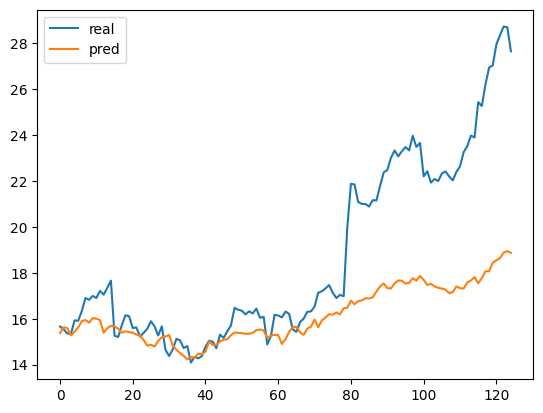

Epoch 1/100
12/12 [==============================] - 1s 30ms/step - loss: 0.0453 - val_loss: 0.0211
Epoch 2/100
12/12 [==============================] - 0s 24ms/step - loss: 0.0115 - val_loss: 0.0132
Epoch 3/100
12/12 [==============================] - 0s 24ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 4/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 5/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 6/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 8/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 9/100
12/12 [==============================] - 0s 22ms/step - loss: 9.3300e-04 - val_loss: 0.0021
Epoch 10/100
12/12 [==============================] - 0s 21ms/step - loss: 8.5196e-04 - val_loss

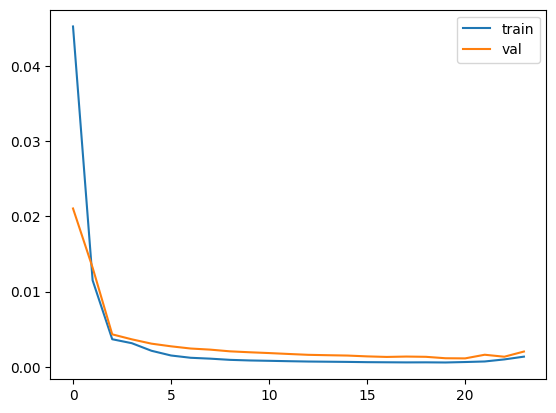

4/4 [==============================] - 0s 3ms/step
(125,)
(125,)


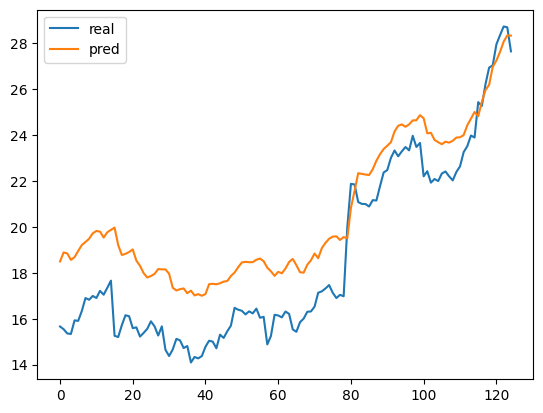

Epoch 1/100
18/18 [==============================] - 1s 24ms/step - loss: 0.0205 - val_loss: 0.0295
Epoch 2/100
18/18 [==============================] - 0s 20ms/step - loss: 0.0095 - val_loss: 0.0190
Epoch 3/100
18/18 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0335
Epoch 4/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0041 - val_loss: 0.0104
Epoch 5/100
18/18 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 6/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 7/100
18/18 [==============================] - 0s 20ms/step - loss: 8.2906e-04 - val_loss: 0.0047
Epoch 8/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 9/100
18/18 [==============================] - 0s 20ms/step - loss: 7.7009e-04 - val_loss: 0.0019
Epoch 10/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss

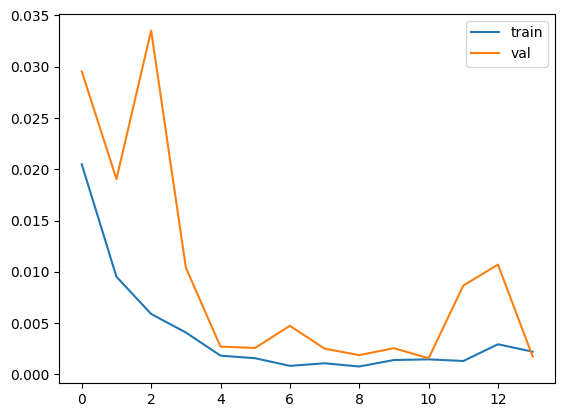

4/4 [==============================] - 0s 3ms/step
(125,)
(125,)


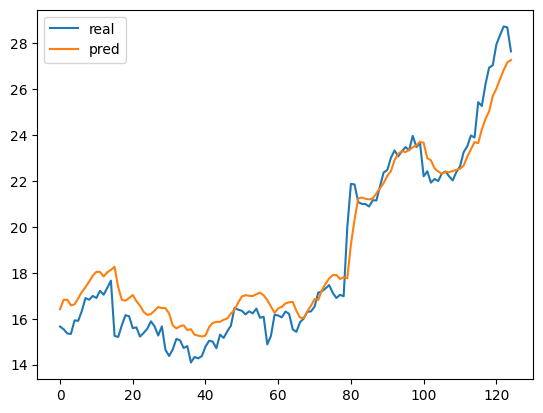

Epoch 1/100
24/24 [==============================] - 1s 22ms/step - loss: 0.0092 - val_loss: 0.0153
Epoch 2/100
24/24 [==============================] - 0s 19ms/step - loss: 0.0373 - val_loss: 0.0131
Epoch 3/100
24/24 [==============================] - 0s 19ms/step - loss: 0.0452 - val_loss: 0.0053
Epoch 4/100
24/24 [==============================] - 0s 19ms/step - loss: 0.0292 - val_loss: 0.0052
Epoch 5/100
24/24 [==============================] - 0s 19ms/step - loss: 0.0097 - val_loss: 0.0249
Epoch 6/100
24/24 [==============================] - 0s 19ms/step - loss: 0.0036 - val_loss: 0.0130
Epoch 7/100
24/24 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0151


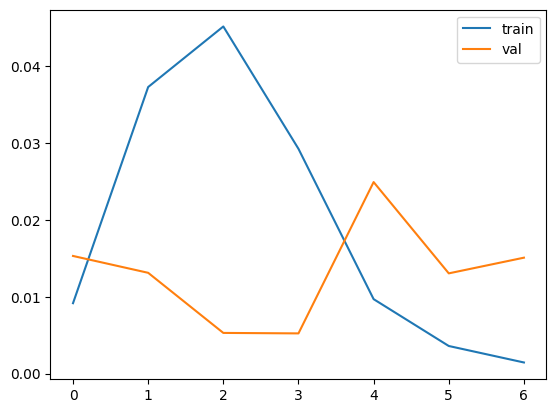

4/4 [==============================] - 0s 3ms/step
(125,)
(125,)


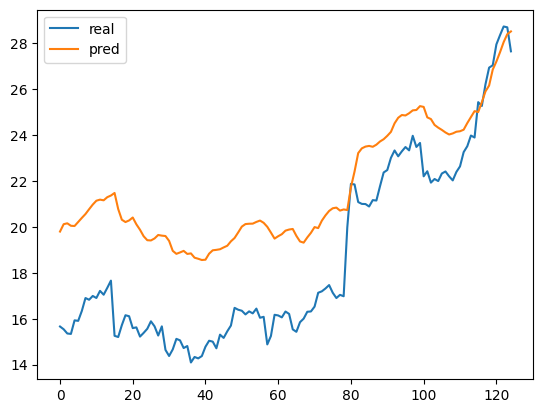

Epoch 1/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0139 - val_loss: 0.0104
Epoch 2/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0289 - val_loss: 0.0369
Epoch 3/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0315 - val_loss: 0.0570
Epoch 4/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0144 - val_loss: 0.0186


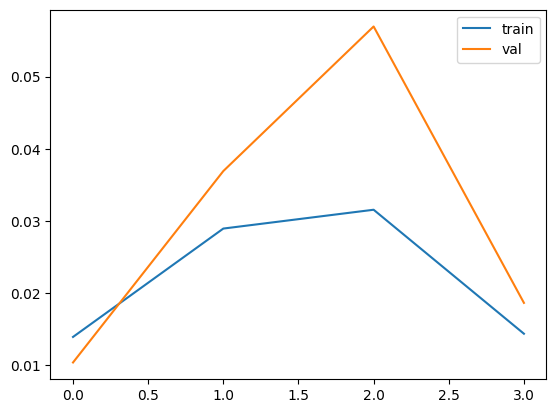

4/4 [==============================] - 0s 3ms/step
(125,)
(125,)


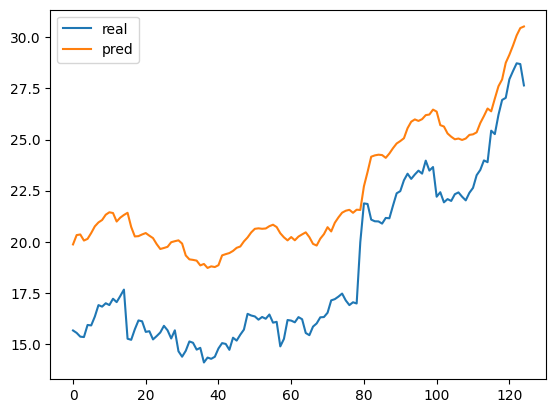

In [287]:
tscv = TimeSeriesSplit(n_splits=5)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=3)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    model.add(GRU(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    #model.add(GRU(3, activation='relu', return_sequences=False))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape

    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    

    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()
